In [1]:
import pykat
from pykat import finesse
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches

#import utils_DRFPMI as utl
   
%matplotlib inline
pykat.init_pykat_plotting(dpi=90)

                                              ..-
    PyKat 1.2.1           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



In [9]:
# 1. Wikiに書いてある鏡間距離と曲率半径を書き込む
# FINESSEで微調整すれば少しずれることもあるが、発注する鏡はWikiに書いてあるものであり、微調整はできない。微調整は鏡の位相だけで行う。


# 2. アシンメトリなどを除去する
# まずは入射ビームのモードを腕に合わせる。
# そのために両腕のモードを揃えておく必要がある。
# 除去するのは、Schnuppアシンメトリと曲率誤差で、
# ロスインバランスは残してもよい。
# さらに、ウェッジ角と折り返し角も0度にしておく。
# この時点でミラーマップは入れない。cavコマンドは両腕のみ。

# 3. ビームパラメタを取得する(tuning1.kat)
# "trace 8"というコマンドラインを追加し、どんな計算でもいいからFINESSEを走らせると、各点でのビームプロファイルがログファイルに表示される。
# レーザーを設置した点でのプロファイルを見て、ウェスト位置とレイリーレンジを得る。
# プロファイルの向きがEOMからレーザーに向かっている場合は、ウェスト位置の符号が逆になることに注意。maxtemは5にしている。

## process 1-3


 --- cavity tracing
 cavity XARM:
  cavity is stable! Eigenvalues:
  q=-1500+774.597j, w0=16.1969667343171mm z=-1.5km m=-0.32964
  finesse : 1548.34, round-trip power loss: 0.0040498 [/100]
  opt. length: 6km, FSR: 49.9654096666667kHz, m: -329.639889196676m
  FWHM: 32.2703889304753Hz (pole: 16.1351944652377Hz)
  (x) A: -2.1578947 B: -3473.6842 C: 0.0012188366 D: 1.498615
  (y) A: -2.1578947 B: -3473.6842 C: 0.0012188366 D: 1.498615
  RT Gouy: -109.246919696117 deg (mode sep.: -15.162686381772kHz)
 cavity YARM:
  cavity is stable! Eigenvalues:
  q=-1500+774.597j, w0=16.1969667343171mm z=-1.5km m=-0.32964
  finesse : 1548.34, round-trip power loss: 0.0040498 [/100]
  opt. length: 6km, FSR: 49.9654096666667kHz, m: -329.639889196676m
  FWHM: 32.2703889304753Hz (pole: 16.1351944652377Hz)
  (x) A: -2.1578947 B: -3473.6842 C: 0.0012188366 D: 1.498615
  (y) A: -2.1578947 B: -3473.6842 C: 0.0012188366 D: 1.498615
  RT Gouy: -109.246919696117 deg (mode sep.: -15.162686381772kHz)
 cavity PRX:
**

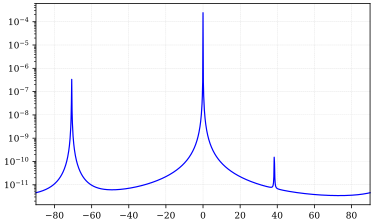

In [5]:
#Schnuppアシンメトリと曲率誤差を除去する。
#ロスインバランスは残してもよい。
#ウェッジ角と折り返し角も0度にしておく。
# この時点でミラーマップは入れない。
#n0のウェスト位置(z)とレイリーレンジ(z_R)を得る。

base = finesse.kat()
base.verbose=False
base.parse("""
    l i1 1.0 0.0 0.0 n0
    s s_eo0 0.0 n0 n_eo1
    mod eom1 16881000.0 0.0 1 pm 0.0 n_eo1 n_eo2    #modulation index=0 
    s s_eo1 0.0 n_eo2 n_eo3
    mod eom2 45015900.0 0.0 1 pm 0.0 n_eo3 n_eo4 #modulation index=0 
    s s_eo2 0.0 n_eo4 REFL

    m PRM 0.8999550000000001 0.1 0.0 REFL npr1
    #m PRM 1.0 0.0 0.0 REFL npr1
    s sLpr1 14.7615 npr1 npr2
    bs PR2 1.0 0.0 0.0 0.0 npr3 npr2 POP POP2
    s sLpr2 11.0661 npr3 npr4
    bs PR3 1.0 0.0 0.0 0.0 dump dump npr4 npr5
    s sLpr3 15.7638 npr5 npr6

    bs bs1 0.5 0.5 0.0 45.0 npr6 n2 n3 n4
    s lx 24.99995 n3 nx1    #(26.6649+23.335)/2
    s ly 24.99995 n2 ny1    #(26.6649+23.335)/2

    ###x arm
    m IXAR 0 1 0 nx1 ntx1
    s thick_IX 0.15 1.754 ntx1 ntx2
    m ITMX 0.996 0.004 0 ntx2 nx2
    s sx1 3000.0 nx2 nx3
    m ETMX 0.99995 5e-06 0.0 nx3 TMSX

    ###y arm
    m IYAR 0 1 0 ny1 nty1
    s thick_IY 0.15 1.754 nty1 nty2
    m ITMY 0.996 0.004 90 nty2 ny2
    s sy1 3000.0 ny2 ny3
    m ETMY 0.99995 5e-06 90.0 ny3 TMSY
    
    s sLsr3 14.7412 n4 nsr5
    bs SR3 1 0 0.0 0 nsr5 nsr4 dump dump
    #bs SR3 0.999905 5e-05 0.0 0.686 nsr5 nsr4 dump dump
    s sLsr2 11.1115 nsr4 nsr3
    bs SR2 1 0.0 0.0 0 nsr2 nsr3 POS dump
    #bs SR2 0.9994550000000001 0.0005 0.0 0.686 nsr2 nsr3 POS dump
    s sLsr1 15.7386 nsr2 nsr1
    m SRM 0.8463550000000001 0.1536 0.0 nsr1 AS
    
    pd0 pd0_DC_REFL REFL
    pd0 pd0_DC_AS AS
    pd0 pd0_DC_TMSX TMSX
    pd0 pd0_DC_TMSY TMSY
    pd0 pd0_DC_POP POP
    pd0 pd0_DC_POS POS

    
    # =========  HOM Expansion =======
    #attr bs1 Rc 0
    attr ITMX Rc -1900.   # measured -1904.6
    attr ETMX Rc 1900.    # measured  1908.24
    attr ITMY Rc -1900    # measured -1904.4
    attr ETMY Rc 1900.    # measured  1905.55
    # =========  from Somiya_example =======
    attr PRM Rc -458.1285 # given in MIF parameter list
    attr SRM Rc 458.1285 # given in MIF parameter list
    attr PR2 Rc -3.0764 # given in MIF parameter list
    attr PR3 Rc 24.9165 # given in MIF parameter list
    attr SR2 Rc -2.9872 # given in MIF parameter list
    attr SR3 Rc 24.9165 # given in MIF parameter list

    cav XARM ITMX nx2 ETMX nx3
    cav YARM ITMY ny2 ETMY ny3

    # =========  Check if the cavity resonates =======
    cav PRX PRM npr1 ITMX ntx2 # unstable #somiya_example
    cav PRY PRM npr1 ITMY nty2  # unstable
    cav SRY SRM nsr1 ITMX ntx2
    cav SRX SRM nsr1 ITMY nty2 #somiya_exaple
    

    """)
base.parse("""
### tuning
pd0 pd0_DC_TMSX TMSX #ETMx transmission
xaxis* ETMX phi lin -90 90 1000
yaxis lin abs
pause 3
trace 10
maxtem 5
""")
a = base.run()
print(a.rundata)

plt.figure(1)
plt.semilogy(a.x, a["pd0_DC_TMSX"])

## process 4

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.

 --- highest order of TEM modes: 5  -> number of fields: 21
  field  |  TEM_nm  (n: x direction, m: y direction)
     0   |   0  0
     1   |   0  1
     2   |   0  2
     3   |   0  3
     4   |   0  4
     5   |   0  5
     6   |   1  0
     7   |   1  1
     8   |   1  2
     9   |   1  3
    10   |   1  4
    11   |   2  0
    12   |   2  1
    13   |   2  2
    14   |   2  3
    15   |   3  0
    16   |   3  1
    17   |   3  2
    18   |   4  0
    19   |   4  1
    20   |   5  0
 
 --- cavity tracing
 cavity XARM:
  cavity is stable! Eigenvalues:
  q=-1500+774.597j, w0=16.1969667343171mm z=-1.5km m=-0.32964
  finesse : 1548.34, round-trip power loss: 0.0040498 [/100]
  opt. length: 6km, FSR: 49.9654096666667kHz, m: -329.639889196676m
  FWHM: 32.2703889304753Hz (pole: 16.1351944652377Hz)
  (x) 

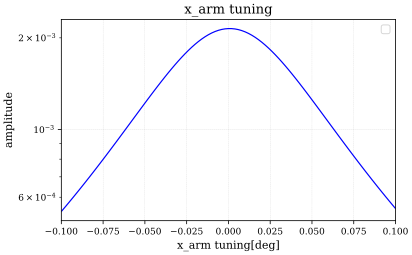

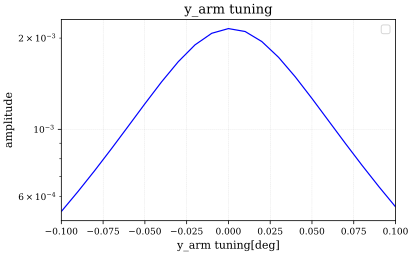

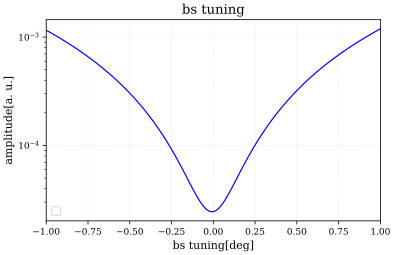

In [18]:
#　4. ミラーマップを入れて位相の調整① (tuning2.kat)
# 除去したアシンメトリや折り返し角を戻す。
# PRMとSRMの反射率をゼロにし、cavコマンドも両腕のみ。
# ミラーマップも入れて、まずはETMxとETMyの位相の調整を行う。(ITMのミラーとETMのミラーを入れた状態で、ETMを合わせる。)
# 腕の透過光が最大になるように各々の位相を合わせる。
# ETMxにのみミラーマップを入れた場合、ETMyの最適位相はゼロのはずである。
# BS の位相の調整は、SRM の透過光が最小になるようにして得る。このときETM に
# 上記の作業で得た位相を加えるのを忘れないこと。また、変調はOFF にしておく。


base = finesse.kat()
base.verbose=False
base.parse("""
    l i1 1.0 0.0 0.0 n0
    s s_eo0 0.0 n0 n_eo1
    mod eom1 16881000.0 0.0 1 pm 0.0 n_eo1 n_eo2
    s s_eo1 0.0 n_eo2 n_eo3
    mod eom2 45015900.0 0.0 1 pm 0.0 n_eo3 n_eo4
    s s_eo2 0.0 n_eo4 REFL

    m PRM 0 1.0 0.0 REFL npr1
    s sLpr1 14.7615 npr1 npr2
    bs PR2 1.0 0.0 0.0 0.686 npr3 npr2 POP POP2
    s sLpr2 11.0661 npr3 npr4
    bs PR3 1.0 0.0 0.0 0.686 dump dump npr4 npr5
    s sLpr3 15.7638 npr5 npr6

    bs bs1 0.5 0.5 0.33 45.0 npr6 n2 n3 n4 #after tuning #0.25ずれていて、0.25に設定して動かしたら0.03ずれている表示がされた。→(0.25+0.03)で設定。ずれが発生する。(繰り返して位相を足していき合わせた)
    #bs bs1 0.5 0.5 0 45.0 npr6 n2 n3 n4
    
    s lx 26.6649 n3 nx1 
    s ly 23.335 n2 ny1 
    ###x arm
    m IXAR 0 1 0 nx1 ntx1
    s thick_IX 0.15 1.754 ntx1 ntx2
    m ITMX 0.996 0.004 0 ntx2 nx2
    s sx1 3000.0 nx2 nx3
    m ETMX 0.99995 5e-06 0.025 nx3 TMSX #after tuning
    #m ETMX 0.99995 5e-06 0.0 nx3 TMSX

    ###y arm
    m IYAR 0 1 0 ny1 nty1
    s thick_IY 0.15 1.754 nty1 nty2
    m ITMY 0.996 0.004 90 nty2 ny2
    s sy1 3000.0 ny2 ny3
    m ETMY 0.99995 5e-06 90.025 ny3 TMSY    #after tuning
    #m ETMY 0.99995 5e-06 90.0 ny3 TMSY

    s sLsr3 14.7412 n4 nsr5
    bs SR3 1 0 0.0 0.686 nsr5 nsr4 dump dump
    s sLsr2 11.1115 nsr4 nsr3
    bs SR2 1 0.0 0.0 0.686 nsr2 nsr3 POS dump
    s sLsr1 15.7386 nsr2 nsr1
    m SRM 0 1.0 0.0 nsr1 AS
    
    pd0 pd0_DC_REFL REFL
    pd0 pd0_DC_AS AS
    pd0 pd0_DC_TMSX TMSX
    pd0 pd0_DC_TMSY TMSY
    pd0 pd0_DC_POP POP
    pd0 pd0_DC_POS POS

    
    # =========  HOM Expansion =======
    #attr bs1 Rc 0
    attr ITMX Rc -1900.   # measured -1904.6
    attr ETMX Rc 1900.    # measured  1908.24
    attr ITMY Rc -1900    # measured -1904.4
    attr ETMY Rc 1900.    # measured  1905.55
    
    # =========  from Somiya_example =======
    attr PRM Rc -458.1285 # given in MIF parameter list
    attr SRM Rc 458.1285 # given in MIF parameter list
    attr PR2 Rc -3.0764 # given in MIF parameter list
    attr PR3 Rc 24.9165 # given in MIF parameter list
    attr SR2 Rc -2.9872 # given in MIF parameter list
    attr SR3 Rc 24.9165 # given in MIF parameter list

    cav XARM ITMX nx2 ETMX nx3
    cav YARM ITMY ny2 ETMY ny3
    gauss* input i1 n0 -16.2047748243985 145.906416503753e-6

    trace 2
    maxtem 5
""")
base_x = base.deepcopy()
base_x.parse("""
    #x mirror map
    map ITMX ITMXhr.txt
    knm ITMX ITMXhrDRFPMI3
    conf ITMX save_knm_binary 1
    conf ITMX interpolation_method 2
    conf ITMX integration_method 1
    conf ITMX knm_change_q 2
   
    map ITMX Apperture.txt
    knm ITMX ITMXabsDRFPMI3
    conf ITMX save_knm_binary 1
    conf ITMX interpolation_method 2
    conf ITMX integration_method 1
    
    
    map ETMX ETMXhr.txt
    knm ETMX ETMXhrDRFPMI3
    conf ETMX save_knm_binary 1
    conf ETMX interpolation_method 2
    conf ETMX integration_method 1

    map ETMX Apperture.txt
    knm ETMX ETMXabsDRFPMI3
    conf ETMX save_knm_binary 1
    conf ETMX interpolation_method 2
    conf ETMX integration_method 1
    
    ### tuning x-arm
    xaxis* ETMX phi lin -0.1 0.1 100
    yaxis lin abs
    pause 3
    
    """)

base_y = base.deepcopy()
base_y.parse("""
    ##y mirror map
    map ITMY Apperture.txt
    knm ITMY ITMYabsDRFPMI3
    conf ITMY save_knm_binary 1
    conf ITMY interpolation_method 2
    conf ITMY integration_method 1

    map ITMY ITMYhr.txt
    knm ITMY ITMYhrDRFPMI3
    conf ITMY save_knm_binary 1
    conf ITMY interpolation_method 2
    conf ITMY integration_method 1

    map ETMY Apperture.txt
    knm ETMY ETMYabsDRFPMI3
    conf ETMY save_knm_binary 1
    conf ETMY interpolation_method 2
    conf ETMY integration_method 1

    map ETMY ETMYhr.txt
    knm ETMY ETMYhrDRFPMI3
    conf ETMY save_knm_binary 1
    conf ETMY interpolation_method 2
    conf ETMY integration_method 1
    
    ### tuning y-arm
    xaxis* ETMY phi lin -0.1 0.1 20
    yaxis lin abs
    pause
    
    """)
base_bs = base.deepcopy()
base_bs.parse("""
    #x mirror map
    map ITMX ITMXhr.txt
    knm ITMX ITMXhrDRFPMI3
    conf ITMX save_knm_binary 1
    conf ITMX interpolation_method 2
    conf ITMX integration_method 1
    conf ITMX knm_change_q 2
   
    map ITMX Apperture.txt
    knm ITMX ITMXabsDRFPMI3
    conf ITMX save_knm_binary 1
    conf ITMX interpolation_method 2
    conf ITMX integration_method 1
    
    
    map ETMX ETMXhr.txt
    knm ETMX ETMXhrDRFPMI3
    conf ETMX save_knm_binary 1
    conf ETMX interpolation_method 2
    conf ETMX integration_method 1

    map ETMX Apperture.txt
    knm ETMX ETMXabsDRFPMI3
    conf ETMX save_knm_binary 1
    conf ETMX interpolation_method 2
    conf ETMX integration_method 1

    ##y mirror map
    map ITMY Apperture.txt
    knm ITMY ITMYabsDRFPMI3
    conf ITMY save_knm_binary 1
    conf ITMY interpolation_method 2
    conf ITMY integration_method 1

    map ITMY ITMYhr.txt
    knm ITMY ITMYhrDRFPMI3
    conf ITMY save_knm_binary 1
    conf ITMY interpolation_method 2
    conf ITMY integration_method 1

    map ETMY Apperture.txt
    knm ETMY ETMYabsDRFPMI3
    conf ETMY save_knm_binary 1
    conf ETMY interpolation_method 2
    conf ETMY integration_method 1

    map ETMY ETMYhr.txt
    knm ETMY ETMYhrDRFPMI3
    conf ETMY save_knm_binary 1
    conf ETMY interpolation_method 2
    conf ETMY integration_method 1
    
    variable dphi 1
    xaxis dphi abs lin -1 1 100
    put* ETMX phi $x1
    put* ITMX phi $x1
    put* ETMY phi $mx1
    put* ITMY phi $mx1
    
    """)

a_x = base_x.run()
a_y = base_y.run()
a_bs = base_bs.run()
print(a_x.rundata)
print(a_y.rundata)
print(a_bs.rundata)
plt.figure(1)
plt.semilogy(a_x.x, a_x["pd0_DC_TMSX"])
plt.title('x_arm tuning')
plt.legend(loc=1)
plt.xlabel("x_arm tuning[deg]")
plt.ylabel("amplitude")

plt.figure(2)
plt.semilogy(a_y.x, a_y["pd0_DC_TMSY"])
plt.title('y_arm tuning')
plt.legend(loc=1)
plt.xlabel("y_arm tuning[deg]")
plt.ylabel("amplitude")

plt.figure(3)
plt.semilogy(a_bs.x, a_bs["pd0_DC_AS"])
plt.title('bs tuning')
plt.legend(loc=1)
plt.xlabel("bs tuning[deg]")
plt.ylabel("amplitude[a. u.]")
plt.legend()

## process 5

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.

 --- cavity tracing
 cavity XARM:
  cavity is stable! Eigenvalues:
  q=-1500+774.597j, w0=16.1969667343171mm z=-1.5km m=-0.32964
  finesse : 1548.34, round-trip power loss: 0.0040498 [/100]
  opt. length: 6km, FSR: 49.9654096666667kHz, m: -329.639889196676m
  FWHM: 32.2703889304753Hz (pole: 16.1351944652377Hz)
  (x) A: -2.1578947 B: -3473.6842 C: 0.0012188366 D: 1.498615
  (y) A: -2.1578947 B: -3473.6842 C: 0.0012188366 D: 1.498615
  RT Gouy: -109.246919696117 deg (mode sep.: -15.162686381772kHz)
 cavity YARM:
  cavity is stable! Eigenvalues:
  q=-1500+774.597j, w0=16.1969667343171mm z=-1.5km m=-0.32964
  finesse : 1548.34, round-trip power loss: 0.0040498 [/100]
  opt. length: 6km, FSR: 49.9654096666667kHz, m: -329.639889196676m
  FWHM: 32.2703889304753Hz (pole: 16.1351944652377Hz)
  (x) A: -2.1578947 B: -3473.6842 C: 0.0012188366 D: 1.498615
  

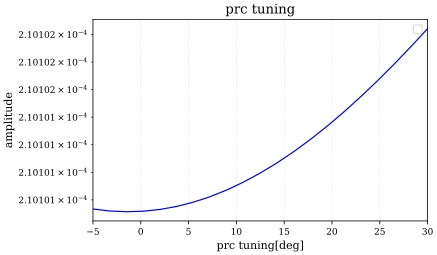

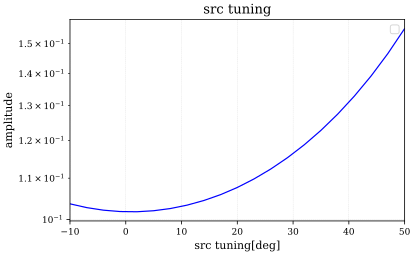

In [19]:
# 5. ミラーマップを入れて位相の調整② (tuning3.kat)
# PRMとSRMの反射率を元に戻し、PRCとSRCのcavコマンドを入れる。
# まず腕の透過光が最大になるようにPRMの位相を調整し、
# 次にadを用いて、腕を差動に振って生成した10kHzの信号が最大になるようにSRMの位相を調整する。
# このときの干渉計構成は、Broadband RSEであると考えられる。
# SRMの位相をこの状態からさらに3.5度ずらせばKAGRAが目指すDetuned RSEとなる。


base = finesse.kat()
base.verbose=False
base.parse("""
   l i1 1.0 0.0 0.0 n0
    s s_eo0 0.0 n0 n_eo1
    mod eom1 16881000.0 0.0 1 pm 0.0 n_eo1 n_eo2
    s s_eo1 0.0 n_eo2 n_eo3
    mod eom2 45015900.0 0.0 1 pm 0.0 n_eo3 n_eo4
    s s_eo2 0.0 n_eo4 REFL

    m PRM 0.8999550000000001 0.1 0 REFL npr1    #no tuning
    s sLpr1 14.7615 npr1 npr2
    bs PR2 1.0 0.0 0.0 0.686 npr3 npr2 POP POP2 #折り返し角のみ追加　#反射率透過率は入れない。
    s sLpr2 11.0661 npr3 npr4
    bs PR3 1.0 0.0 0.0 0.686 dump dump npr4 npr5　#折り返し角のみ追加　#反射率透過率は入れない。
    s sLpr3 15.7638 npr5 npr6

    bs bs1 0.5 0.5 0.33 45.0 npr6 n2 n3 n4 
    
    s lx 26.6649 n3 nx1
    s ly 23.335 n2 ny1

    ###x arm
    m IXAR 0 1 0 nx1 ntx1
    s thick_IX 0.15 1.754 ntx1 ntx2
    m ITMX 0.996 0.004 0 ntx2 nx2
    s sx1 3000.0 nx2 nx3
    m ETMX 0.99995 5e-06 0.025 nx3 TMSX 

    ###y arm
    m IYAR 0 1 0 ny1 nty1
    s thick_IY 0.15 1.754 nty1 nty2
    m ITMY 0.996 0.004 90 nty2 ny2
    s sy1 3000.0 ny2 ny3
    m ETMY 0.99995 5e-06 90.025 ny3 TMSY    
    
    s sLsr3 14.7412 n4 nsr5
    bs SR3 1 0 0.0 0.686 nsr5 nsr4 dump dump
    s sLsr2 11.1115 nsr4 nsr3
    bs SR2 1 0.0 0.0 0.686 nsr2 nsr3 POS dump
    s sLsr1 15.7386 nsr2 nsr1
    m SRM 0.8463550000000001 0.1536 0 nsr1 AS   #no tuning(x+3.5)
    
    pd0 pd0_DC_REFL REFL
    pd0 pd0_DC_TMSY TMSY
    pd0 pd0_DC_POP POP
    pd0 pd0_DC_POS POS

    
    # =========  HOM Expansion =======
    #attr bs1 Rc 0
    attr ITMX Rc -1900.   # measured -1904.6
    attr ETMX Rc 1900.    # measured  1908.24
    attr ITMY Rc -1900    # measured -1904.4
    attr ETMY Rc 1900.    # measured  1905.55
    
    # =========  from Somiya_example =======
    attr PRM Rc -458.1285 # given in MIF parameter list
    attr SRM Rc 458.1285 # given in MIF parameter list
    attr PR2 Rc -3.0764 # given in MIF parameter list
    attr PR3 Rc 24.9165 # given in MIF parameter list
    attr SR2 Rc -2.9872 # given in MIF parameter list
    attr SR3 Rc 24.9165 # given in MIF parameter list

    cav XARM ITMX nx2 ETMX nx3
    cav YARM ITMY ny2 ETMY ny3
    cav PRX PRM npr1 ITMX ntx2 # unstable #somiya_example
    cav PRY PRM npr1 ITMY nty2  # unstable
    cav SRY SRM nsr1 ITMX ntx2
    cav SRX SRM nsr1 ITMY nty2 #somiya_exaple
    
    gauss* input i1 n0 -16.2047748243985 145.906416503753e-6

    map ITMX ITMXhr.txt
    knm ITMX ITMXhrDRFPMI3
    conf ITMX save_knm_binary 1
    conf ITMX interpolation_method 2
    conf ITMX integration_method 1
    conf ITMX knm_change_q 2
   
    map ITMX Apperture.txt
    knm ITMX ITMXabsDRFPMI3
    conf ITMX save_knm_binary 1
    conf ITMX interpolation_method 2
    conf ITMX integration_method 1
    
    
    map ETMX ETMXhr.txt
    knm ETMX ETMXhrDRFPMI3
    conf ETMX save_knm_binary 1
    conf ETMX interpolation_method 2
    conf ETMX integration_method 1

    map ETMX Apperture.txt
    knm ETMX ETMXabsDRFPMI3
    conf ETMX save_knm_binary 1
    conf ETMX interpolation_method 2
    conf ETMX integration_method 1
    
    
    map ITMY Apperture.txt
    knm ITMY ITMYabsDRFPMI3
    conf ITMY save_knm_binary 1
    conf ITMY interpolation_method 2
    conf ITMY integration_method 1

    map ITMY ITMYhr.txt
    knm ITMY ITMYhrDRFPMI3
    conf ITMY save_knm_binary 1
    conf ITMY interpolation_method 2
    conf ITMY integration_method 1

    map ETMY Apperture.txt
    knm ETMY ETMYabsDRFPMI3
    conf ETMY save_knm_binary 1
    conf ETMY interpolation_method 2
    conf ETMY integration_method 1

    map ETMY ETMYhr.txt
    knm ETMY ETMYhrDRFPMI3
    conf ETMY save_knm_binary 1
    conf ETMY interpolation_method 2
    conf ETMY integration_method 1
    
    trace 2
    maxtem 5

    """)

base_prc = base.deepcopy()
base_prc.parse("""
    ### tuning PRC
    pd0 pd0_DC_TMSX TMSX
    xaxis* PRM phi lin -5 30 20
    yaxis lin abs
    pause 3
""")
base_src = base.deepcopy()
base_src.parse("""
    ### tuning SRC
    
    pd0 pd0_DC_TMSX TMSX
    fsig sig1 ETMX 10k 0
    fsig sig2 ETMY 10k 180
    ad pd 0 0 10k AS
    xaxis* SRM phi lin -10 50 20 
    yaxis lin abs
    pause 3
    
""")
a_p = base_prc.run()
a_s = base_src.run()
print(a_p.rundata)
print(a_s.rundata)

plt.figure(1)
plt.semilogy(a_p.x, a_p["pd0_DC_TMSX"])
plt.title('prc tuning')
plt.legend(loc=1)
plt.xlabel("prc tuning[deg]")
plt.ylabel("amplitude")

plt.figure(2)
plt.semilogy(a_s.x, a_s["pd"])
plt.title('src tuning')
plt.legend(loc=1)
plt.xlabel("src tuning[deg]")
plt.ylabel("amplitude")

plt.legend()

### add Add transmittance and reflectance for PRC and SRC

No handles with labels found to put in legend.


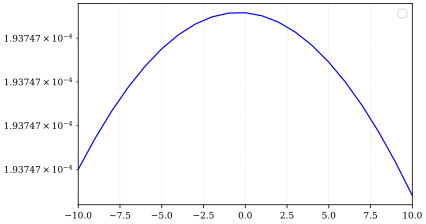

In [6]:
base = finesse.kat()
base.verbose=False
base.parse("""
    l i1 1.0 0.0 0.0 n0
    s s_eo0 0.0 n0 n_eo1
    mod eom1 16881000.0 0.3 3 pm 0.0 n_eo1 n_eo2
    s s_eo1 0.0 n_eo2 n_eo3
    mod eom2 45015900.0 0.3 3 pm 0.0 n_eo3 n_eo4
    s s_eo2 0.0 n_eo4 REFL

    #m PRM 0.8999550000000001 0.1 0 REFL npr1
    m PRM 0.8999550000000001 0.1 -5.0 REFL npr1 #after tuning
    s sLpr1 14.7615 npr1 npr2
    bs PR2 0.9994550000000001 0.0005 0.0 0.686 npr3 npr2 POP POP2
    #bs PR2 1.0 0.0 0.0 0.686 npr3 npr2 POP POP2
    s sLpr2 11.0661 npr3 npr4
    bs PR3 0.999905 5e-05 0.0 0.686 dump dump npr4 npr5
    #bs PR3 1.0 0.0 0.0 0.686 dump dump npr4 npr5
    s sLpr3 15.7638 npr5 npr6

    bs bs1 0.5 0.5 14.5 45.0 npr6 n2 n3 n4
    s lx 26.6649 n3 nx1 
    s ly 23.335 n2 ny1 
    
    m ITMX 0.995955 0.004 0.0 nx1 nx2
    s sx1 3000.0 nx2 nx3
    m ETMX 0.99995 5e-06 0.025 nx3 TMSX
    
    m ITMY 0.995955 0.004 90.0 ny1 ny2
    s sy1 3000.0 ny2 ny3
    m ETMY 0.99995 5e-06 90.0 ny3 TMSY
    
    s sLsr3 14.7412 n4 nsr5
    #bs SR3 1 0 0.0 0.686 nsr5 nsr4 dump dump
    bs SR3 0.999905 5e-05 0.0 0.686 nsr5 nsr4 dump dump
    s sLsr2 11.1115 nsr4 nsr3
    #bs SR2 1 0.0 0.0 0.686 nsr2 nsr3 POS dump
    bs SR2 0.9994550000000001 0.0005 0.0 0.686 nsr2 nsr3 POS dump
    s sLsr1 15.7386 nsr2 nsr1
    #m SRM 0.8463550000000001 0.1536 0 nsr1 AS
    m SRM 0.8463550000000001 0.1536 14.5 nsr1 AS  #(after tuning)
    
    pd0 pd0_DC_REFL REFL
    pd0 pd0_DC_AS AS
    pd0 pd0_DC_TMSX TMSX
    pd0 pd0_DC_TMSY TMSY
    pd0 pd0_DC_POP POP
    pd0 pd0_DC_POS POS

    
    # =========  HOM Expansion =======
    #attr bs1 Rc 0
    attr ITMX Rc -1900.   # measured -1904.6
    attr ETMX Rc 1900.    # measured  1908.24
    attr ITMY Rc -1900    # measured -1904.4
    attr ETMY Rc 1900.    # measured  1905.55
    
    # =========  from Somiya_example =======
    attr PRM Rc -458.1285 # given in MIF parameter list
    attr SRM Rc 458.1285 # given in MIF parameter list
    attr PR2 Rc -3.0764 # given in MIF parameter list
    attr PR3 Rc 24.9165 # given in MIF parameter list
    attr SR2 Rc -2.9872 # given in MIF parameter list
    attr SR3 Rc 24.9165 # given in MIF parameter list

    cav XARM ITMX nx2 ETMX nx3
    cav YARM ITMY ny2 ETMY ny3
    cav srcN SRM nsr1 ITMY ny1
    cav prcN PRM npr1 ITMX nx1
    gauss* input i1 n0 -16.2049916742242 151.291549306146e-6

    map ITMX ITMXhr.txt
    knm ITMX ITMXhrDRFPMI2
    conf ITMX save_knm_binary 1
    conf ITMX interpolation_method 2
    conf ITMX integration_method 1
    conf ITMX knm_change_q 2
   
    map ITMX Apperture.txt
    knm ITMX ITMXabsDRFPMI2
    conf ITMX save_knm_binary 1
    conf ITMX interpolation_method 2
    conf ITMX integration_method 1
    
    
    map ETMX ETMXhr.txt
    knm ETMX ETMXhrDRFPMI2
    conf ETMX save_knm_binary 1
    conf ETMX interpolation_method 2
    conf ETMX integration_method 1

    map ETMX Apperture.txt
    knm ETMX ETMXabsDRFPMI2
    conf ETMX save_knm_binary 1
    conf ETMX interpolation_method 2
    conf ETMX integration_method 1
    
    
    map ITMY Apperture.txt
    knm ITMY ITMYabsDRFPMI2
    conf ITMY save_knm_binary 1
    conf ITMY interpolation_method 2
    conf ITMY integration_method 1

    map ITMY ITMYhr.txt
    knm ITMY ITMYhrDRFPMI2
    conf ITMY save_knm_binary 1
    conf ITMY interpolation_method 2
    conf ITMY integration_method 1

    map ETMY Apperture.txt
    knm ETMY ETMYabsDRFPMI2
    conf ETMY save_knm_binary 1
    conf ETMY interpolation_method 2
    conf ETMY integration_method 1

    map ETMY ETMYhr.txt
    knm ETMY ETMYhrDRFPMI2
    conf ETMY save_knm_binary 1
    conf ETMY interpolation_method 2
    conf ETMY integration_method 1
    ### tuning PRC
    pd0 pd0_DC_TMSX TMSX
    xaxis* PRM phi lin -10 10 20
    yaxis lin abs
    pause
    ### tuning SRC
    
    /*
    pd0 pd0_DC_TMSX TMSX
    fsig sig1 ETMX 10k 0
    fsig sig2 ETMY 10k 180
    ad pd 0 0 10k AS
    xaxis* SRM phi lin -10 50 20 
    yaxis lin abs
    pause
    */
    

trace 8
maxtem 5
""")
a = base.run()

plt.figure(1)
plt.semilogy(a.x, a["pd0_DC_TMSX"])
plt.legend()

#plt.figure(2)
#plt.semilogy(a.x, a["pd"])
#plt.legend()

No handles with labels found to put in legend.


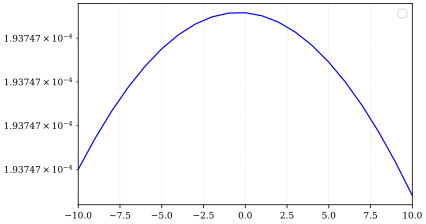

In [7]:
# flat mirror 

# 5. のあと、PR、SRの反射率透過率を追加

base = finesse.kat()
base.verbose=False
base.parse("""
    l i1 1.0 0.0 0.0 n0
    s s_eo0 0.0 n0 n_eo1
    mod eom1 16881000.0 0.3 3 pm 0.0 n_eo1 n_eo2
    s s_eo1 0.0 n_eo2 n_eo3
    mod eom2 45015900.0 0.3 3 pm 0.0 n_eo3 n_eo4
    s s_eo2 0.0 n_eo4 REFL

    #m PRM 0.8999550000000001 0.1 0 REFL npr1
    m PRM 0.8999550000000001 0.1 -5.0 REFL npr1 #after tuning
    s sLpr1 14.7615 npr1 npr2
    bs PR2 0.9994550000000001 0.0005 0.0 0.686 npr3 npr2 POP POP2
    #bs PR2 1.0 0.0 0.0 0.686 npr3 npr2 POP POP2
    s sLpr2 11.0661 npr3 npr4
    bs PR3 0.999905 5e-05 0.0 0.686 dump dump npr4 npr5
    #bs PR3 1.0 0.0 0.0 0.686 dump dump npr4 npr5
    s sLpr3 15.7638 npr5 npr6

    bs bs1 0.5 0.5 14.5 45.0 npr6 n2 n3 n4
    s lx 26.6649 n3 nx1 
    s ly 23.335 n2 ny1 
    
    m ITMX 0.995955 0.004 0.0 nx1 nx2
    s sx1 3000.0 nx2 nx3
    m ETMX 0.99995 5e-06 0.025 nx3 TMSX
    
    m ITMY 0.995955 0.004 90.0 ny1 ny2
    s sy1 3000.0 ny2 ny3
    m ETMY 0.99995 5e-06 90.0 ny3 TMSY
    
    s sLsr3 14.7412 n4 nsr5
    #bs SR3 1 0 0.0 0.686 nsr5 nsr4 dump dump
    bs SR3 0.999905 5e-05 0.0 0.686 nsr5 nsr4 dump dump
    s sLsr2 11.1115 nsr4 nsr3
    #bs SR2 1 0.0 0.0 0.686 nsr2 nsr3 POS dump
    bs SR2 0.9994550000000001 0.0005 0.0 0.686 nsr2 nsr3 POS dump
    s sLsr1 15.7386 nsr2 nsr1
    #m SRM 0.8463550000000001 0.1536 0 nsr1 AS
    m SRM 0.8463550000000001 0.1536 14.5 nsr1 AS  #(after tuning)
    
    pd0 pd0_DC_REFL REFL
    pd0 pd0_DC_AS AS
    pd0 pd0_DC_TMSX TMSX
    pd0 pd0_DC_TMSY TMSY
    pd0 pd0_DC_POP POP
    pd0 pd0_DC_POS POS

    
    # =========  HOM Expansion =======
    #attr bs1 Rc 0
    attr ITMX Rc -1900.   # measured -1904.6
    attr ETMX Rc 1900.    # measured  1908.24
    attr ITMY Rc -1900    # measured -1904.4
    attr ETMY Rc 1900.    # measured  1905.55
    
    # =========  from Somiya_example =======
    attr PRM Rc -458.1285 # given in MIF parameter list
    attr SRM Rc 458.1285 # given in MIF parameter list
    attr PR2 Rc -3.0764 # given in MIF parameter list
    attr PR3 Rc 24.9165 # given in MIF parameter list
    attr SR2 Rc -2.9872 # given in MIF parameter list
    attr SR3 Rc 24.9165 # given in MIF parameter list

    cav XARM ITMX nx2 ETMX nx3
    cav YARM ITMY ny2 ETMY ny3
    cav srcN SRM nsr1 ITMY ny1
    cav prcN PRM npr1 ITMX nx1
    gauss* input i1 n0 -16.2049916742242 151.291549306146e-6

    
    map ITMX ITMXhr.txt
    knm ITMX ITMXhrDRFPMI2
    conf ITMX save_knm_binary 1
    conf ITMX interpolation_method 2
    conf ITMX integration_method 1
    conf ITMX knm_change_q 2
   
    map ITMX Apperture.txt
    knm ITMX ITMXabsDRFPMI2
    conf ITMX save_knm_binary 1
    conf ITMX interpolation_method 2
    conf ITMX integration_method 1
    
    
    map ETMX ETMXhr.txt
    knm ETMX ETMXhrDRFPMI2
    conf ETMX save_knm_binary 1
    conf ETMX interpolation_method 2
    conf ETMX integration_method 1

    map ETMX Apperture.txt
    knm ETMX ETMXabsDRFPMI2
    conf ETMX save_knm_binary 1
    conf ETMX interpolation_method 2
    conf ETMX integration_method 1
    
    
    map ITMY Apperture.txt
    knm ITMY ITMYabsDRFPMI2
    conf ITMY save_knm_binary 1
    conf ITMY interpolation_method 2
    conf ITMY integration_method 1

    map ITMY ITMYhr.txt
    knm ITMY ITMYhrDRFPMI2
    conf ITMY save_knm_binary 1
    conf ITMY interpolation_method 2
    conf ITMY integration_method 1

    map ETMY Apperture.txt
    knm ETMY ETMYabsDRFPMI2
    conf ETMY save_knm_binary 1
    conf ETMY interpolation_method 2
    conf ETMY integration_method 1

    map ETMY ETMYhr.txt
    knm ETMY ETMYhrDRFPMI2
    conf ETMY save_knm_binary 1
    conf ETMY interpolation_method 2
    conf ETMY integration_method 1
    
    ### tuning PRC
    pd0 pd0_DC_TMSX TMSX
    xaxis* PRM phi lin -10 10 20
    yaxis lin abs
    pause
    ### tuning SRC
    
    /*
    pd0 pd0_DC_TMSX TMSX
    fsig sig1 ETMX 10k 0
    fsig sig2 ETMY 10k 180
    ad pd 0 0 10k AS
    xaxis* SRM phi lin -10 50 20 
    yaxis lin abs
    pause
    */
    trace 8
    maxtem 5
""")
a = base.run()
#print(a.rundata)

plt.figure(1)
plt.semilogy(a.x, a["pd0_DC_TMSX"])
plt.legend()

#plt.figure(2)
#plt.semilogy(a.x, a["pd"])
#plt.legend()